# Overview
Here, we predict whether a human is going to make a mistake in a given chess position. More precisely, we estimate both the expected centi-pawn loss and the expected blunder (CP loss > 200) probability given a player's Elo rating. We base this analysis on a dataset of 23,000 games that have been fully evaluated by a computer (1.9 Million evaluations).

This model can be used in a variety of ways:
  1. If we hold the Elo constant, these predictions are, intuitively, a good measure a position's sharpness, since players will be more likely to make mistakes in sharp positions. 
  2. We can understand how players of certain strength play in certain positions. For instance, some positions are handled almost perfectly by elite players, but beginners will likely blunder in them.
  
At a high level, our model supplements the computer evaluation of a position. A widely held belief among chess players is that a computer evaluation is less important when a position is sharp. To quantify this belief, we need a definition of sharpness, and our predictive score is tailored to this purpose.

The predictions (CP loss or blunder probability) are obtained from a supervised model that simply predicts the same outcome in a large sample of games.

**We have turned this model into an interactive [web app](https://chessinsights.org/analysis/)! So you can just go there and see what you think of the results**. You can also check out [the database](https://chessinsights.org) and even add your own games for evaluation!

## Comparison to previous work

Existing research (Guid and Bratko, 2006, G-B going forward) has defined sharpness using the change in evaluation as an engine's depth increases. This measure has the advantage that it is very easy to obtain when running computer evaluations. We find that our measure is only weakly correlated with the G-B measure.

## Next steps

These predictions can be used to create "human evaluations" of a given chess position. Specifically, one can ask the following: Given a certain chess position, what is the best move I should play to win the game? The best move (highest win probability) might not have the highest computer evaluation, and a crucial factor is that humans make mistakes when the position is sharp.

## Notes on the model

Currently, our model tries to minimize the required prior knowledge about chess. The input is simply a position's FEN, and this is split into a large vector and fed into a two-stage dense neural network.

# Validation overview: Candidates 2018
Here, we present an overview of the validation and analyses with the data. You can also think of this as "fun statistics we can create with our model".

We use games from the Candidates 2018 to evalute our results.  We can use this tournament to investigate whether our results are reasonable. First, we present how sharply each participant played.

We find that Levon Aronian played the sharpest chess, and Wesley So played least sharply. The one surprising result is that one would expect Vladimir Kramnik to show up more highly in the list, because his play was widely deemed to be extremely dynamic.

In [261]:
player_stats

,Predicted Sharpness,CP Loss
last_name_white,,
Aronian,18.64,26.84
Caruana,17.49,15.01
Ding,17.99,16.05
Grischuk,16.70,16.90
Karjakin,17.32,19.17
Kramnik,17.50,15.23
Mamedyarov,16.10,14.52
So,14.94,11.77


## Game Statistics
We now investigate how sharply each game was played. Overall, these results feel sensible. A likely reason is that, by averaging predictions over a number of moves, this statistic eliminates noise in the prediction.

The comparison between the "sharpest" and "least sharp" games is stark: The sharpest games consistently involve huge complexity and attacking chess. The least sharp games usually involve quick piece exchanges and simplification into a drawn endgame.

## Sharpest Games

In [267]:
game_stats.head(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
0,3449,Caruana,Mamedyarov,25.71,16.02
1,3454,Grischuk,Ding,25.01,33.92
2,3457,Aronian,Grischuk,23.68,29.31
3,3483,Ding,Grischuk,23.65,23.96
4,3476,Karjakin,Kramnik,23.44,24.66
5,3468,Kramnik,Ding,22.42,10.92
6,3442,Karjakin,Mamedyarov,20.85,24.54
7,3466,Aronian,Caruana,20.03,35.51
8,3482,Aronian,Karjakin,19.81,24.25
9,3489,Mamedyarov,Grischuk,19.01,11.82


## Least sharp games

In [268]:
game_stats.tail(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
46,3447,Mamedyarov,Aronian,13.92,9.83
47,3467,Grischuk,Mamedyarov,13.74,8.38
48,3479,Ding,So,13.57,8.00
49,3491,So,Karjakin,13.56,7.00
50,3458,Caruana,Karjakin,13.56,11.03
51,3460,Ding,Mamedyarov,13.55,11.42
52,3484,So,Mamedyarov,13.54,12.51
53,3471,Mamedyarov,Karjakin,13.52,11.93
54,3480,Grischuk,Karjakin,13.52,7.11
55,3475,Aronian,Mamedyarov,13.37,9.76


## Example positions
This is the most intuitive validation: We simply show positions that are deemed either sharp or non-sharp, and chess players can get a feeling for whether these predictions are sensible.

In [256]:
df = df_cand.query('10 <= move_number <= 30').sort_values('pred_sharpness', ascending=False)

### Sharp

In [257]:
df_sharp = df.head(100)
df_sharp.pred_sharpness.mean()

29.73249

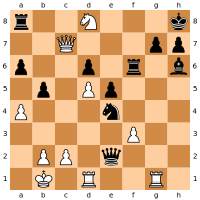

In [258]:
fen_to_svg(df_sharp.fen.iloc[0])

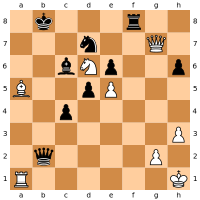

In [259]:
fen_to_svg(df_sharp.fen.iloc[1])

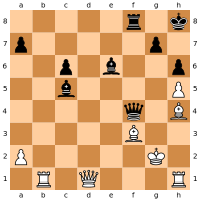

In [260]:
fen_to_svg(df_sharp.fen.iloc[2])

### Not sharp

In [252]:
df_nonsharp = df.tail(100)
df_nonsharp.pred_sharpness.mean()

13.0591955

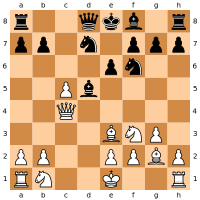

In [253]:
fen_to_svg(df_nonsharp.fen.iloc[0])

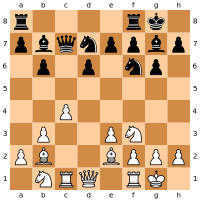

In [254]:
fen_to_svg(df_nonsharp.fen.iloc[1])

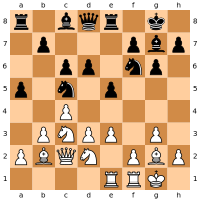

In [255]:
fen_to_svg(df_nonsharp.fen.iloc[2])

# Analysis

In [1]:
# Ignoring warnings here.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import pandas.io.sql as sqlio
from sklearn.ensemble import RandomForestRegressor

import statsmodels
import statsmodels.formula.api as smf

import chess
import chess.svg
from IPython.display import SVG

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
import chess
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LeakyReLU

In [3]:
import queries
import functions as f
import imp
imp.reload(queries); imp.reload(f);

In [4]:
pd.set_option('precision', 2)
pd.set_option('display.width', 200)
pd.set_option('max_colwidth',90)

use_dev = False
connstring = f.CONNSTRING_DEV if use_dev else f.CONNSTRING_PROD

conn = psycopg2.connect(connstring)
params = {
  'move_number_start': 20
, 'move_number_end': 40
}

# Loading the raw data

In [5]:
df_games = sqlio.read_sql_query(queries.q_games, conn).rename(columns={'id': 'game_id'})
df_db = sqlio.read_sql_query(queries.q_db, conn).rename(columns={'id': 'database_id'})
df_players = sqlio.read_sql_query(queries.q_players, conn).rename(columns={'id': 'player_id'})
df_tournaments = sqlio.read_sql_query(queries.q_tournaments, conn).rename(columns={'id': 'tournament'})
df_attributes = sqlio.read_sql_query("SELECT * from game_attribute", conn)

In [6]:
df_eval_raw = sqlio.read_sql_query("SELECT * from move_eval", conn)
len(df_eval_raw)

1954808

In [278]:
df = df_games.merge(df_attributes
                    .query('attribute=="BlackElo"')[['game_id', 'value']]
                   .rename(columns={'value': 'elo_black'}))
df = df.merge(df_attributes
                    .query('attribute=="WhiteElo"')[['game_id', 'value']]
                    .rename(columns={'value': 'elo_white'}))
df = df.merge(df_players[['player_id', 'last_name']].rename(
    columns={'player_id': 'player_white_id', 'last_name': 'last_name_white'}), on='player_white_id')
df = df.merge(df_players[['player_id', 'last_name']].rename(
    columns={'player_id': 'player_black_id', 'last_name': 'last_name_black'}), on='player_black_id')
df = df.merge(df_tournaments[['tournament', 'name']].rename(
    columns={'name': 'tournament_name'}), on='tournament')
df = df[df.elo_white!=""]
df = df[df.elo_black!=""]
for var in ['elo_white', 'elo_black']:
    df[var] = df[var].astype(int)

In [280]:
cols_add = ['tournament', 'tournament_name', 'game_id', 
            'elo_white', 'elo_black', 
            'last_name_white', 'last_name_black',
            'player_white_id', 'player_black_id']
df_eval = df_eval_raw.merge(df[cols_add])

In [281]:
summary = {
    'Number of evaluations': len(df_eval),
    'Number of games': df_eval.game_id.nunique(),
    'Number of players': df_eval.player_white_id.nunique()
}
summary

{'Number of evaluations': 1931417,
 'Number of games': 23562,
 'Number of players': 11866}

In [118]:
tournament_cand = df_tournaments.query('name=="FIDE Candidates 2018"').tournament.iloc[0]
tournament_cand

132

In [119]:
tournaments_eval = [tournament_cand]

# Cleaning the data

In [120]:
MAX_CP_LOSS = 200

cploss_raw = (-1 + 2 * df_eval.is_white) * (df_eval.eval_best - df_eval['eval'])

df_eval['cploss'] = f.top_and_bottom(cploss_raw, 0, MAX_CP_LOSS)
df_eval['is_blunder'] = 1 * cploss_raw >= 200
df_eval['eval_lagged'] = df_eval.groupby('game_id').eval_best.shift(1)
df_eval['avg_cp_loss'] = df_eval.groupby('game_id').cploss.transform(np.mean)
df_eval = df_eval.query('is_white')

df_eval['fen_simple'] = [s[1] for s in df_eval.fen.str.split(' ')]

df_eval['is_excluded'] = df_eval.tournament.isin(tournaments_eval)

In [122]:
df_eval[['is_blunder', 'cploss']].mean()

is_blunder     0.02
cploss        21.53
dtype: float64

In [123]:
def fen_clean(fen):
    cleaned = fen
    for number in range(1, 9):
        cleaned = cleaned.replace(str(number), 'E' * number)
    cleaned = cleaned.replace('/', '')
    assert len(cleaned) == 64
    return cleaned

In [124]:
all_pieces = 'pPnNbBrRqQkK'
def fen_to_pieces(fen):
    pieces = fen_clean(fen)
    return [piece == p for piece in pieces for p in all_pieces]

In [125]:
castling_values = 'kKqQ'
def castling_rights(rights):
    return [v in rights for v in castling_values]

In [126]:
def fen_covars(fen):
    s = fen.split(' ')
    s_pos = s[1]
    s_castle = s[3]
    covars_pos = fen_to_pieces(s_pos)
    covars_castle = castling_rights(s_castle)
    is_white = s[2] == 'w'
    return covars_pos + covars_castle #+ [is_white]

In [152]:
ELO_SCALE = 3000

In [127]:
def fen_features(row):
    #return [row.elo_white]
    covars_fen = fen_covars(row.fen)
    return covars_fen + [row.elo_white / ELO_SCALE]

In [143]:
ix = df_eval.cploss.notnull()
df_reg = df_eval[ix] #

df_reg = df_reg.sample(len(df_reg)) #.sample(len(df_reg))
df_reg = df_reg[df_reg.cploss.notnull()].copy()
df_reg['val'] = (np.random.random(len(df_reg)) > 0.8) | (df_reg.is_excluded)

df_train = df_reg.query('not val').copy()
df_val = df_reg.query('val').copy()

X_train = np.array([fen_features(row[1]) for row in df_train.iterrows()]).astype(float)
X_val = np.array([fen_features(row[1]) for row in df_val.iterrows()]).astype(float)

In [144]:
outcomes = ['cploss', 'is_blunder']
stds = df_train[outcomes].std()
Y_train = np.array(df_train[outcomes] / stds)
Y_val = np.array(df_val[outcomes] / stds)
n_covars = X_train.shape[1]

In [145]:
stds

cploss        36.74
is_blunder     0.13
dtype: float64

In [146]:
X_train.shape, Y_train.shape, Y_val.shape

((773789, 773), (773789, 2), (195919, 2))

In [147]:
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[n_covars]) , #, , 
    keras.layers.Dropout(0.5),
    #LeakyReLU(alpha=0.05),
    layers.Dense(5, activation='sigmoid'),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(Y_train.shape[1])
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               77400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 505       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 12        
Total params: 77,917
Trainable params: 77,917
Non-trainable params: 0
_________________________________________________________________


In [148]:
optimizer = tf.keras.optimizers.Adamax(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
model.build()

In [149]:
hist = model.fit(X_train, Y_train, epochs=30, batch_size=1000, validation_data=(X_val, Y_val), verbose=1)

Train on 773789 samples, validate on 195919 samples
Epoch 1/30
773789/773789 [==============================] - 5s 7us/sample - loss: 0.9721 - mae: 0.4485 - mse: 0.9721 - val_loss: 0.9601 - val_mae: 0.4446 - val_mse: 0.9601
Epoch 2/30
773789/773789 [==============================] - 5s 6us/sample - loss: 0.9490 - mae: 0.4415 - mse: 0.9490 - val_loss: 0.9438 - val_mae: 0.4411 - val_mse: 0.9438
Epoch 3/30
773789/773789 [==============================] - 5s 6us/sample - loss: 0.9351 - mae: 0.4376 - mse: 0.9351 - val_loss: 0.9368 - val_mae: 0.4232 - val_mse: 0.9368
Epoch 4/30
773789/773789 [==============================] - 5s 6us/sample - loss: 0.9244 - mae: 0.4341 - mse: 0.9244 - val_loss: 0.9303 - val_mae: 0.4269 - val_mse: 0.9303
Epoch 5/30
773789/773789 [==============================] - 4s 6us/sample - loss: 0.9174 - mae: 0.4332 - mse: 0.9174 - val_loss: 0.9309 - val_mae: 0.4221 - val_mse: 0.9309
Epoch 6/30
773789/773789 [==============================] - 5s 6us/sample - loss: 0.9096

In [150]:
model.save('sharpness.h5')

# Validation

## What is the predictive power of the score?
Here, we look at the correlation between the score and the actual loss. We find that it stands at around 0.28. By holding the player's ELO constant, we obtain a measure of a position's sharpness, we find that this is still correlated decently with the outcome variables (0.24).

There is no clear sense of how good this performance is. In future work, we plan to investigate how this prediction compares to human estimates of sharpness.

In [186]:
ELO_ELITE = 2800
df_val['pred'] = model.predict(X_val)[:, 0] * stds['cploss']
X_val_2 = X_val.copy()
X_val_2[:, -1] = ELO_ELITE / ELO_SCALE
df_val['pred_sharpness'] = model.predict(X_val_2)[:, 0] * stds['cploss']
df_val.query('is_white')[['cploss', 'elo_white', 'pred', 'pred_sharpness']].corr() * 100

,cploss,elo_white,pred,pred_sharpness,complexity_g_b
cploss,100.00,-14.08,28.63,24.39,8.39
elo_white,-14.08,100.00,-30.95,-1.12,1.11
pred,28.63,-30.95,100.00,83.13,5.81
pred_sharpness,24.39,-1.12,83.13,100.00,6.10
complexity_g_b,8.39,1.11,5.81,6.10,100.00


In [158]:
df_val[['cploss', 'pred_sharpness']].mean()

cploss            21.64
pred_sharpness    16.47
dtype: float64

## Comparison to Guid and Bratko
We find that the correlation between the estimates sharpenss and the Guid-And-Bratko measure is relatively small, at about 0.06. This does not imply that our measure is superior, simply that the measures are very different. We plan to investigate when certain measures are better than others.

In [188]:
df_val[['pred_sharpness', 'complexity_g_b']].corr() * 100

,pred_sharpness,complexity_g_b
pred_sharpness,100.0,6.1
complexity_g_b,6.1,100.0


# Evaluating the results: 2018 Candidates

In [165]:
df_cand = df_val[df_val.tournament == tournament_cand]

## Sharpness by player

In [262]:
player_stats = (
    df_cand.query('is_white').groupby('last_name_white')['pred_sharpness', 'cploss']
    .mean()
    .rename(columns={'pred_sharpness': 'Predicted Sharpness', 'cploss': 'CP Loss'}))
player_stats

,Predicted Sharpness,CP Loss
last_name_white,,
Aronian,18.64,26.84
Caruana,17.49,15.01
Ding,17.99,16.05
Grischuk,16.70,16.90
Karjakin,17.32,19.17
Kramnik,17.50,15.23
Mamedyarov,16.10,14.52
So,14.94,11.77


## Game statistics

In [265]:
group_vars = ['game_id', 'last_name_white', 'last_name_black']
game_stats = (
    df_cand.groupby(group_vars)[['pred_sharpness', 'cploss']]
    .mean()
    .sort_values('pred_sharpness', ascending=False)
    .reset_index()
    .rename(columns={'pred_sharpness': 'Predicted Sharpness', 'cploss': 'CP Loss'})
)

### Sharpest games

In [266]:
game_stats.head(10)

,game_id,last_name_white,last_name_black,Predicted Sharpness,CP Loss
0,3449,Caruana,Mamedyarov,25.71,16.02
1,3454,Grischuk,Ding,25.01,33.92
2,3457,Aronian,Grischuk,23.68,29.31
3,3483,Ding,Grischuk,23.65,23.96
4,3476,Karjakin,Kramnik,23.44,24.66
5,3468,Kramnik,Ding,22.42,10.92
6,3442,Karjakin,Mamedyarov,20.85,24.54
7,3466,Aronian,Caruana,20.03,35.51
8,3482,Aronian,Karjakin,19.81,24.25
9,3489,Mamedyarov,Grischuk,19.01,11.82


### Least sharp games

In [183]:
game_stats.tail(10)

game_id  last_name_white  last_name_black
3447     Mamedyarov       Aronian            13.92
3467     Grischuk         Mamedyarov         13.74
3479     Ding             So                 13.57
3491     So               Karjakin           13.56
3458     Caruana          Karjakin           13.56
3460     Ding             Mamedyarov         13.55
3484     So               Mamedyarov         13.54
3471     Mamedyarov       Karjakin           13.52
3480     Grischuk         Karjakin           13.52
3475     Aronian          Mamedyarov         13.37
Name: pred_sharpness, dtype: float32